# Variational Auto Encoders (VAE)

**темы:** задача реконструкции, классический автоэнкодер, переход к вариационной постановке задачи, reparametrization trick, VAE и вариационный loss, свойства и применение VAE

**Автор:** Федоров Артем Максимович

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Задача сжатия данных. Auto Encoder

Во многих задачах наблюдения $x \in \mathcal{D}$ не заполняют всё пространство $\mathbb{R}^d$, а располагаются вблизи некоторого низкоразмерного множества (часто мы считаем его многообразием в всюду плотных пространствах, как например Евклидовом). Для такого множества естественно говорить о внутренней (локальной) размерности $m$: это число независимых степеней свободы, которыми можно “плавно” менять объект, оставаясь среди допустимых/реалистичных объектов.

При чем такое поведение наблюдается не только у экзотических объектов, таким свойством обладают изображения, аудио, временные ряды, табличные признаки после кодирования. Мы не можем знать точно это самое $m$, но можем исходя из каких-либо предположений (например просто через перебор) оценить его некоторым $k$. Очевидное предложение – в большой размерности учить что-либо / взаимодействовать с объектами – сложно $\Rightarrow$ давайте перейдем от исходного описания $x \in \mathbb{R}^d$ к более компактному описанию $x \in \mathbb{R}^k,$ сохранив при этом максимум информации об изначальном объекте.


**Пример многообразия данных**

<p align="center">
  <img src="images/lecture_3/manifold.png" style="width:60%;">
</p>



Данная задача компрессии хорошо формализуется в метрическом пространстве: 

- строится отображение **энкодер** $E$, которое переводит объект в компактный код:
$$E: \mathbb{R}^d \to \mathbb{R}^k \quad \quad z=E(x), \,\,\, x \in \mathbb{R}^d, z \in \mathbb{R}^k,k << d$$

- строится отображение **декодер** $D$, которое восстанавливает объект из кода:
$$D: \mathbb{R}^k \to \mathbb{R}^d \quad \quad \hat{x} = D(z) = D(E(x))$$


- $\mathcal{D}$ – распределение данных (или эмпирический датасет)
- $\ell(\cdot , \cdot)$ – функция ошибки (в частности MSE для вещественных признаков)


Пара $(E,D)$ подбирается из некоторого класса функций так, чтобы минимизировать ошибку реконструкции на данных:

$$\min_{E,D} \mathbb{E}_{x \sim \mathcal{D}} \left[ \ell(x, D(E(x))) \right]$$


<p align="center">
  <img src="images/lecture_3/AE.png" style="width:60%;">
</p>

Данная архитектура получила название AE – Auto Encoder – кодировщик, что для каждого объекта на инференсе самостоятельно побирает код в соответствии с тем, что он видел на обучающей выборке

## Bottle-neck

Отображение $E$ физически не может “переписать” вход без потерь: оно вынуждено выбирать, какие компоненты $x$ наиболее важны для восстановления. В этом смысле $z$ становится сжатым признаком объекта — представлением, которое:

1) сохраняет существенные факторы вариативности данных

2) игнорирует часть неинформативных, неважных деталей/шума (если это допускается функцией потерь и архитектурой)



> Однако не все так радужно: не зря мы заострили внимание, что мы не знаем о размерности $m$ и самом характере многообразия, на котором лежат данные. 

<p align="center">
  <img src="images/lecture_3/dim_reduction.png" style="width:40%;">
</p>

### Проблема сжатия при k < m

Если $m>k$, то перейти от $x$ к $z \in \mathbb{R}^k$ без потери информации по определению невозможно: отображение в пространство меньшей размерности неизбежно “склеивает” разные состояния данных. На практике это проявляется в том, что при слишком малом $k$ реконструкция вынужденно теряет часть факторов вариативности: тонкие детали исчезают, а близкие по смыслу, но различающиеся по отдельным параметрам объекты получают слишком похожие коды.

> Эта проблема связана не с неудачной оптимизацией или выбором $E/D$, а с самой геометрией задачи: при недостаточной размерности латентного пространства все степени свободы данных одновременно сохранить нельзя.





<p align="center">
  <img src="images/lecture_3/bottleneck_disaster.png" style="width:40%;">
</p>



### Проблема выразительности энкодера

Даже при “достаточном” $k$ остаётся вопрос, способен ли энкодер $E$ извлекать нужные факторы вариативности (признаки) из наблюдения $x$. Если реальная структура данных задаётся сложными нелинейными зависимостями (сложные изгибы многообразия, смещения факторов, сложная корреляционная структура признаков), то класс функций, в котором выбирается $E$, должен быть достаточно выразительным, чтобы:

- отделять существенные факторы вариативности от второстепенных деталей,

- отображать близкие по смыслу объекты в близкие коды,

- давать представление, из которого декодер $D$ может стабильно восстанавливать $x$.

**Например** Линейные модели в этом смысле ограничены: они способны описывать лишь линейную структуру (запомнить, что $x_{i > m} \approx \sum_{j=1}^m w_j x_j$). Нелинейные энкодеры (например, нейросети) расширяют класс допустимых отображений и позволяют аппроксимировать существенно более сложные геометрии данных (например полиномиальные, локально экспоненциальные зависимости и так далее).

## Примеры построения AE

Дальнейшее зависит от выбора класса функций для $E$ и $D$

### Случай 1: линейные отображения

Если ограничиться линейными функциями:
$$E(x) = W_1 x, \quad\quad D(z) = W_2 z$$

и выбрать квадратичную ошибку реконструкции (MSE), то задача сводится к поиску наилучшего линейного подпространства размерности $k$, на которое проектируются данные. Это приводит к классическому решению через PCA (главные компоненты): выбираются направления максимальной дисперсии, обеспечивающие наименьшую среднеквадратичную ошибку при восстановлении.

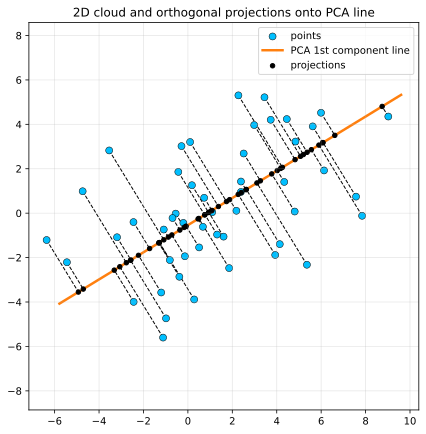

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# --- 1) Generate a tilted 2D point cloud (~30°) ---
n = 50
theta = np.deg2rad(30)

R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

# Anisotropic cloud (elongated), then rotate by ~30°
scales = np.array([4.0, 2])       # std along the cloud's major/minor axes
X = np.random.normal(size=(n, 2)) * scales
X = X @ R.T                          # rotate
X += np.array([0.5, -0.2])           # small shift

# --- 2) PCA via SVD on centered data ---
mu = X.mean(axis=0)
Xc = X - mu

U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
pc1 = Vt[0]                          # direction of the 1st principal component (unit vector)

# --- 3) Orthogonal projection of each point onto the PCA line ---
proj_scalar = Xc @ pc1               # scalar coordinates along pc1
X_proj = mu + np.outer(proj_scalar, pc1)

# Build a line segment for visualization
t = np.linspace(proj_scalar.min() - 1.0, proj_scalar.max() + 1.0, 100)
line = mu + np.outer(t, pc1)

# --- 4) Plot: points, PCA line, and perpendicular projection segments ---
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], s=50, c='deepskyblue', edgecolors='k', linewidths=0.5, label='points')
plt.plot(line[:, 0], line[:, 1], linewidth=2.5, label='PCA 1st component line', c='tab:orange', zorder=-1)

plt.scatter(X_proj[:, 0], X_proj[:, 1], s=20, c='k', label='projections')

# Perpendicular segments from each point to its projection on the line
for i in range(n):
    plt.plot([X[i, 0], X_proj[i, 0]], [X[i, 1], X_proj[i, 1]], linewidth=1, linestyle='--', c='black', zorder=-100)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.title('2D cloud and orthogonal projections onto PCA line')
plt.legend()
plt.show()

### Случай 2: нелинейные отображения

Если допускаются нелинейные $E$ и $D$, то задача уже не имеет аналитического решения в общем случае. Очевидным способом усилить $E/D$, имея при этом возможность их все же обучить, является параметризация этих функций нейросетями. Оптимизация ведётся численно (градиентными методами). Получается AutoEncoder как общий механизм обучения представлений через реконструкцию.

## AE как генератор

Если декодер задан как хорошая непрерывная функция и действительно приближает параметризацию многообразия реальных объектов $x$, то автоматически ему присущи два свойства:

1) **Локальная устойчивость**. Для двух близких латентных кодов $z$ и $z + \Delta z$ ожидается близость декодированных объектов $D(z)$ и $D(z + \Delta z)$ из условия непрерывности отображения $D$. Тогда небольшие сдвиги в $z$ соответствуют небольшим изменениям объекта в пространстве данных.

2) **Латентные траектории**. Для непрерывной траектории $z(t)$ декодированные точки $D(z(t))$ образуют непрерывную траекторию в пространстве объектов. Это создаёт конструктивную интерпретацию: движение в латентном пространстве соответствует движению вдоль множества реалистичных объектов


Тогда если мы можем каким-то образом попасть в область валидных кодов, при этом не в один из тех $z_i = E(x_i)$, то его декодировка даст нам так же валидный объект $\Rightarrow$ композицию вот такого выбора объекта $z$ в латентном пространстве и проход через декодер можно рассматривать как **Генеративное отображение**

<p align="center">
  <img src="images/lecture_3/localization_latent_space.png" style="width:60%;">
</p>

### Наивная схема генерации

Наиболее прямолинейный вариант генерации выглядит так:

1) выбрать случайный $z \in \mathbb{R}^k$ из простого распределения (например, $\mathcal{N}(0,I)$ или равномерного на некотором диапазоне)

2) получить объект $x_{\text{new}} = D(z)$

В терминах геометрии такая процедура требует, чтобы латентное пространство было “хорошо устроено”: значительная доля точек, которые выдаёт выбранное распределение, должна соответствовать осмысленным объектам после декодирования, то есть в окрестностях всех точек, что мы чемплируем из распределения, автоэнкодер должен отвечать двум поставленным ранее условиям.

### Какие здесь возникают проблемы

Самое очевидно – получаемае распределение генерируемых объектов не обязано никак походить на распределние реальных данных (мы просто на это не обучали модель)

$$p_D \not\approx p^\ast$$

Более того, сами генерируемые объекты при помощи такой наивной схемы тоже не гарантированно будут "правдивыми"! Оптимизация реконструкции фиксирует поведение декодера главным образом на множестве кодов, которые реально встречаются как $E(x)$ для объектов из датасета

$$\mathcal{Z}_\text{data} = \left\{E(x) \right\}$$

Вне этой области требования к $D(z)$ напрямую не задаются. Поэтому мы имеем гарантии, что новые объекты будут "правдивы" только локально, в окрестностях $athcal{Z}_\text{data}$, но не обязательно глобально во всём $\mathbb{R}^k$ или частично на носителе распределения, из которого мы семплируем латенты. 

<p align="center">
  <img src="images/lecture_3/latent_space_collapse.png" style="width:70%;">
</p>

## Пример обучения Auto Encoder

Научимся делать представления для объектов MNIST датасета

In [1]:
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from tqdm import tqdm
from torch import optim
from matplotlib import pyplot as plt

import sys
if sys.version_info[0] < 3:
    raise Exception("Must be using Python 3")

if sys.version_info[1] >= 7:
    from contextlib import nullcontext
else:
    class nullcontext:
        def __init__(self, enter_context=None):
            self.enter_context = enter_context

        def __enter__(self):
            return self.enter_context

        def __exit__(self, *args, **kwargs):
            return None

from tqdm import tqdm as tqdm

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data_raw = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
train_data = TensorDataset(train_data_raw.tensors[0].round())
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)
test_data = TensorDataset(test_data_raw.tensors[0].round())

/mnt/virtual_ai0001071-01239_SR006-nfs2/micromamba/envs/af_latent_v3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/mnt/virtual_ai0001071-01239_SR006-nfs2/micromamba/envs/af_latent_v3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/mnt/virtual_ai0001071-01239_SR006-nfs2/micromamba/envs/af_latent_v3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/mnt/virtual_ai0001071-01239_SR006-nfs2/micromamba/envs/af_latent_v3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


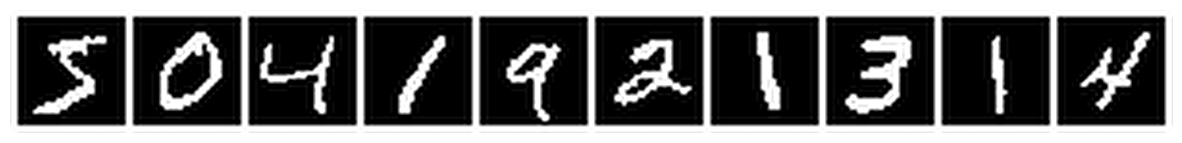

In [3]:
def show_images(x, scale=15, line_width=10):
    plt.figure(figsize=(scale, scale / line_width * (x.shape[0] // line_width + 1)))
    x = x.view(-1, 1, 28, 28)
    mtx = torchvision.utils.make_grid(x, nrow=line_width, pad_value=1)
    plt.imshow(mtx.permute([1, 2, 0]).numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')

show_images(train_data[:10][0])

utils

In [4]:
n = 15
digit_size = 28

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def drow_reconstruction(ae, data, num_samples=10):
    if isinstance(data, torch.Tensor):
        x = data[:num_samples]
    else:
        batch = next(iter(DataLoader(data, batch_size=num_samples, shuffle=True)))
        x = batch[0] if isinstance(batch, (list, tuple)) else batch

    x = x.to(next(ae.parameters()).device)
    with torch.no_grad():
        recon = ae.decode(ae.encode(x))

    images = torch.cat([x, recon], dim=0).cpu()
    show_images(images, scale=12, line_width=num_samples)


def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(reversed(grid_x)):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

def draw_latent_space(data, target, encoder):
    z_test = encoder(data)
    plt.figure(figsize=(7, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=target, cmap='gist_rainbow', alpha=0.75)
    plt.colorbar()
    plt.show()

def draw_manifold_ae(model):
    generator = lambda z: model.decode(torch.from_numpy(z).float()).cpu().view(28, 28).data.numpy()
    return draw_manifold(generator)

validation and train cycles

In [5]:
def validation(compute_loss, data, batch_size=128, num_samples=None, verbose=False):
    """
    Computes averaged loss function over the test data.

    Args:
        compute_loss: Callable(batch) -> float. Loss on batch, batch is torch.FloatTensor.
        data: Dataset for testing.
        batch_size: Batch size for evaluation.
        num_samples: If set, stop after this many samples. None = use whole dataset.
        verbose: Whether to print progress.

    Returns:
        float: Estimated loss over the data.
    """
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=(num_samples is None))
    samples_processed = 0
    avg_loss = 0
    raw_iterator = enumerate(dataloader)
    with (tqdm(raw_iterator, total=len(dataloader)) if verbose else nullcontext(raw_iterator)) as iterator:
        for i, batch in iterator:
            samples_processed += int(batch[0].shape[0])
            if len(batch) == 1:
                batch = batch[0]
            loss = compute_loss(batch)
            avg_loss += (loss - avg_loss) / (i + 1)
            if verbose:
                iterator.set_description('Test loss: %.3f' % avg_loss)
            if num_samples and samples_processed >= num_samples:
                break
    return avg_loss


In [6]:
def train_model(parameters, batch_loss, train_data, test_data=None, num_samples=1000,
                maximization=True, tests_per_epoch=5, batch_size=64, num_epochs=5,
                learning_rate=1e-3):
    """
    Performs stochastic gradient descent or ascent over batch_loss
    and stores the learning progress.

    Args:
        parameters: Model parameters to optimize.
        batch_loss: Callable(batch) -> scalar tensor. Differentiable loss for batch.
        train_data: Dataset for training.
        test_data: Dataset for validation. If None, validation is skipped.
        num_samples: Number of samples for validation. Used when test_data is provided.
        maximization: If True, maximize batch_loss; otherwise minimize.
        tests_per_epoch: How many times per epoch to run validation.
        batch_size: Batch size for training and validation.
        num_epochs: Number of training epochs.
        learning_rate: Learning rate for Adam optimizer.

    Returns:
        dict with keys:
            train_losses_list: List of batch loss values.
            test_results: Dict mapping 'validation_loss' to list of validation scores.
            num_epochs: Number of epochs.
    """
    gd = optim.Adam(parameters, lr=learning_rate)

    train_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        num_batches_between_tests = len(dataloader) // tests_per_epoch + 1
        avg_train_loss = 0

        with tqdm(enumerate(dataloader), total=len(dataloader)) as iterator:
            for batch_num, batch in iterator:
                if len(batch) == 1:
                    batch = batch[0]
                gd.zero_grad()
                loss = batch_loss(batch)
                if maximization:
                    (-loss).backward()
                else:
                    loss.backward()
                gd.step()

                train_losses.append(float(loss.detach()))

                avg_train_loss += (float(loss) - avg_train_loss) / (batch_num + 1)
                iterator.set_description('Train loss: %.3f' % avg_train_loss)

                if (batch_num % num_batches_between_tests == 0 or
                        (epoch == num_epochs - 1 and batch_num == len(dataloader) - 1)):
                    if test_data is not None:
                        val_loss = validation(
                            lambda b: float(batch_loss(b).detach()),
                            test_data,
                            batch_size=batch_size,
                            num_samples=num_samples,
                            verbose=False
                        )
                        validation_losses.append(val_loss)

    return {
        'train_losses_list': train_losses,
        'test_results': {'validation_loss': validation_losses},
        'num_epochs': num_epochs,
    }

model

In [76]:
class AE(nn.Module):
    def __init__(self, d, D):
        """
        Initialize model weights.

        Args:
            d: Dimensionality of the latent space.
            D: Dimensionality of the object space.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.encoder = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.d)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid(),
        )
        self.to('cuda')

    def encode(self, x):
        """
        Generate a latent code given the objects.

        Args:
            x: Tensor of shape n x D.

        Returns:
            Tensor of shape n x d.
        """
        assert x.shape[-1] == self.D, f'wrong X dimensions: supposed be {self.D}, got {x.shape[-1]} instead'
        return self.encoder(x.to('cuda'))

    def decode(self, z):
        """
        Generate objects given the latent representations.

        Args:
            z: Tensor of shape n x d, the latent representations.

        Returns:
            Tensor of shape n x D.
        """
        assert z.shape[-1] == self.d, f'wrong z dimensions: supposed be {self.d}, got {z.shape[-1]} instead'
        return self.decoder(z.to('cuda'))

    def batch_loss(self, batch):
        """
        Compute batch loss. Average of per-object losses.
        Per-object loss = reconstruction L2-error + L2-regularization of latents.
        Tip: use sum (not mean) of per-pixel L2-errors and L2-regularization.
        Returned scalar must be differentiable w.r.t. model weights.

        Args:
            batch: Tensor of shape n x D.

        Returns:
            Scalar tensor, loss for the batch.
        """
        batch = batch.to('cuda')
        latents = self.encode(batch)
        recon_x = self.decode(latents)
        
        latent_l2  = (latents ** 2).sum(-1)
        loss_recon = ((recon_x - batch) ** 2).sum(-1)
        return (latent_l2 + loss_recon).mean()
        
    @torch.no_grad
    def generate_samples(self, num_samples):
        """
        Generate samples from standard normal in latent space.

        Args:
            num_samples: Number of samples to generate.

        Returns:
            Tensor of shape num_samples x D.
        """
        latents = torch.randn(num_samples, self.d).to('cuda')
        return self.decode(latents).detach().cpu()

### Обучение модели с двух мерным латентным пространством

In [86]:
ae_d2 = AE(2, 784)
ae_d2.to('cuda')
ae_d2_train_log = train_model(ae_d2.parameters(), ae_d2.batch_loss, train_data,
                              test_data=test_data, num_samples=1000,
                              maximization=False, num_epochs=25)

drow_reconstruction(ae_d2, test_data, num_samples=10)

torch.save(ae_d2.state_dict(), 'auto_encoder_experiment_2d.dill')

Train loss: 95.099:   5%|▍         | 43/938 [00:00<00:02, 424.54it/s] 

Train loss: 45.559: 100%|██████████| 938/938 [00:01<00:00, 535.40it/s]


In [87]:
ae_d2 = AE(2, 784)
ae_d2.to('cuda')
ae_d2.load_state_dict(torch.load('auto_encoder_experiment_2d.dill'))

<All keys matched successfully>

### Визуализация результатов для AE с двух мерным латентным пространством

реконструкция

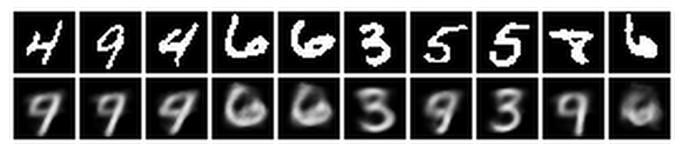

In [ ]:
drow_reconstruction(ae_d2, test_data, num_samples=10)

генерация объектов из латентного пространства

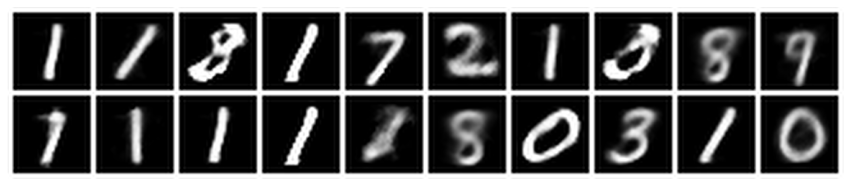

In [93]:
show_images(ae_d2.generate_samples(20).detach().cpu())

отображение латентного пространства

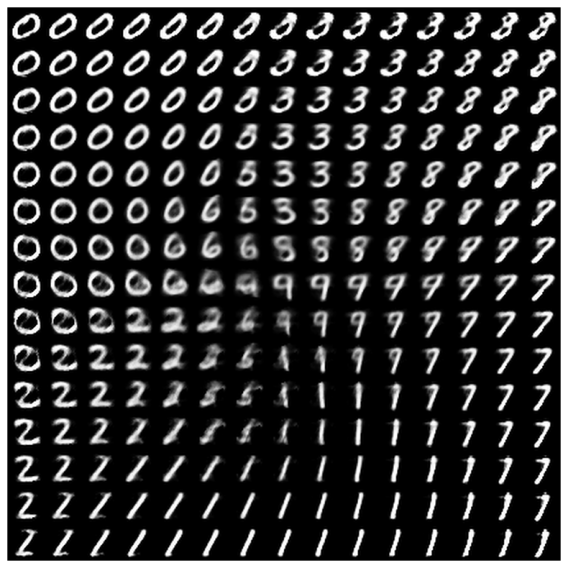

In [89]:
draw_manifold_ae(ae_d2)

как выглядит карта латентного пространства

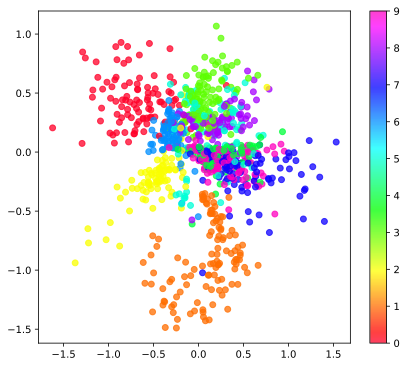

In [91]:
draw_latent_space(test_data_raw.tensors[0][::10], test_data_raw.tensors[1][::10],
                  lambda data: ae_d2.encode(data).detach().cpu())

### Как будет работать AE с 10 мерным латентным пространством?

In [90]:
ae_d10 = AE(10, 784)
ae_d10.to('cuda')
ae_d10_train_log = train_model(ae_d10.parameters(), ae_d10.batch_loss, train_data,
                              test_data=test_data, num_samples=1000,
                              maximization=False, num_epochs=25)

torch.save(ae_d2.state_dict(), 'auto_encoder_experiment_10d.dill')

Train loss: 22.739: 100%|██████████| 938/938 [00:01<00:00, 560.67it/s]


### Визуализация латентного пространства k=10

In [ ]:
ae_d10 = AE(10, 784)
ae_d10.to('cuda')
ae_d10.load_state_dict(torch.load('auto_encoder_experiment_10d.dill'))

реконструкция

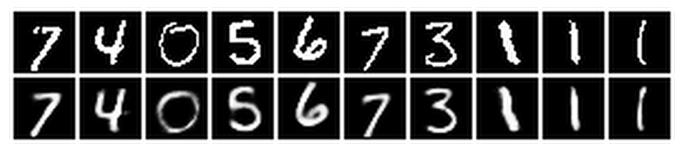

In [98]:
drow_reconstruction(ae_d10, test_data, num_samples=10)

генерация объектов из латентного пространства

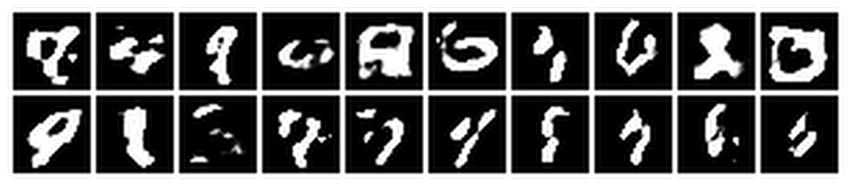

In [99]:
show_images(ae_d10.generate_samples(20).detach().cpu())

как выглядит карта латентного пространства

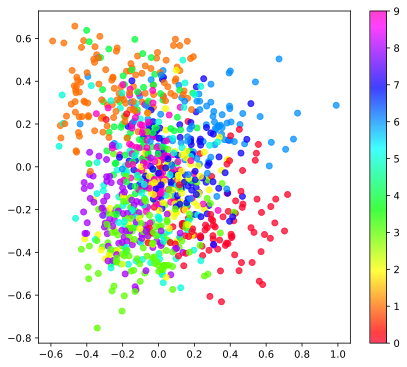

In [100]:
draw_latent_space(test_data_raw.tensors[0][::10], test_data_raw.tensors[1][::10],
                  lambda data: ae_d10.encode(data).detach().cpu())

# Переход к вероятностному моделированию. Variational Auto Encoder

Детерминированная постановка автоэнкодера фиксирует лишь задачу реконструкции $x \approx D(E(x))$. Такая цель обучает отображения $E / D$, но не задаёт вероятностную модель данных: отсутствует распределение $p_\theta(x)$, которое можно было бы сопоставить с наблюдениями и из которого можно было бы корректно семплировать новые объекты. И как мы ранее убедились, ничего хорошего из попыток использования такой модели для задач генерации не вышло.

## Шаблон латентной генеративной модели

Почему мы вообще хотим видеть латентную переменную? – По ней (по информации внутри нее) мы можем восстановить объект. В рамках генеративной парадигмы, мы взглянем на латенту не как на информацию для восстановления одного объекта $x$, а как на информацию, что позволяет восстановить сразу распределение объектов $p(x \mid z)$, что будет существенно проще, чем оригинальное $p^\ast(x)$. 

Далее мы введем расширенное пространство $\mathcal{X} \times \mathcal{Z}$. Латентная модель задаётся совместным распределением:

$$p_\theta(x, z) = p_\theta(x \mid z) p(z)$$

- $p(z)$ – простой prior в латентном пространстве $Z$ (далее будем считать это всегда $\mathcal{N}(0,I)$, хотя это не единственный вариант)

- $p_\theta(x \mid z)$ – условно простое параметричекое распределение при фиксированном латенте, играющее роль (вариационного) декодера.

Заметим, что мы все еще можем получить оригинальное распределение на $\mathcal{X}$: 

$$p_\theta(x) = \int p_\theta(x \mid z) p(z) dz$$

но теперь модель явно разделена на две части: (i) простая мера в $\mathcal{Z}$, (ii) отображение/механизм переноса этой меры в пространство данных. Обратное соответствие $x \to z$ напрямую не задаётся (что нам еще аукнется в будущем).


<p align="center">
  <img src="images/lecture_3/latent_simplification.png" style="width:90%;">
</p>

Как мы заметили еще на первой лекции, для обучения такой генеративной модели, то есть $p_\theta \to p^\ast$, нам нужно максимизировать логарифм правдоподобия нашей наблюдаемой выборки: 

$$\max_\theta \log p_\theta(\mathcal{D}) = \max_\theta \sum_{i=1}^N \log p_\theta(x_i) = \max_\theta \sum_{i=1}^N \log \int p_\theta(x_i \mid z) p(z) dz $$


### Генерация из такой модели

После обучения генерация реализуется единым сценарием всегда:

1) Семплируем латенту $z \sim p(z)$
2) Семплируем объект $x \sim p_\theta(x \mid z)$

Смысл выбора простого prior $p(z)$ заключается в том, что операции семплирования и манипуляции в $\mathcal{Z}$ (интерполяции, сдвиги) становятся тривиальными (мы как бы живем в локальных прямоугольных координатах); геометрия данных переносится в механизм $p_\theta(x\mid z)$ и в согласование апостериора с prior через вариационный функционал.

<p align="center">
  <img src="images/lecture_3/sampling.png" style="width:80%;">
</p>

## Вывод VAE

Классическая PCA допускает вероятностную интерпретацию, если задать линейную “генерацию” наблюдения из латента:

$$p_\theta(x \mid z) = \mathcal{N}(x \mid Wz + b, \sigma^2 I), \quad \quad p(z) = \mathcal{N}(0, I)$$

- $\theta = \left\{W \in \mathbb{R}^{d\times k}, b \in \mathbb{R}^d \right\}$

- $\sigma^2 I$ – шум наблюдений

- среднее $Wz + b$ задает линейное подпространство размерности $k$


Мы уже помним, что такой Автоэнкодер обладает крайне плохой выразительностью. А давайте упростим задачу – пусть теперь вместо $Wz + b$ будет просто нейросеть $f_\theta(z)$. Но вот беда – для нелинейной функции $f_\theta$ мы больше не можем найти явное решение (аналитическое) как в случае с обычным PCA, но и обучать напрямую градиентным спуском функционал не получится из-за интеграла под $\log$

### Откуда проблема

Интеграл под логарифмом:

$$\log p_\theta(x) = \log \int p_\theta (x \mid z) p(z) dz$$

неудобен по двум причинам: 

1) Вычислительная: даже если $p_\theta(x \mid z)$ легко считается, интеграл по $z$ в общем случае не берётся аналитически (особенно когда $f_\theta$ — нейросеть)

2) Статистическая: при обучении по правдоподобию неизбежно возникает апостериорное распределение $p_\theta(z \mid x)$

$$
\begin{align*}
\log p_\theta(x)
&= \log \int p_\theta(x\mid z)\,p(z)\,dz \\[4pt]
&= \log \int q(z\mid x)\,\frac{p_\theta(x\mid z)\,p(z)}{q(z\mid x)}\,dz \\[4pt]
&= \log \,\mathbb{E}_{q(z\mid x)}
\left[\frac{p_\theta(x\mid z)\,p(z)}{q(z\mid x)}\right] \\[6pt]
&\ge \mathbb{E}_{q(z\mid x)}
\left[\log \frac{p_\theta(x\mid z)\,p(z)}{q(z\mid x)}\right]
\qquad \text{(неравенство Йенсена)} \\[8pt]
&= \mathbb{E}_{q(z\mid x)}\big[\log p_\theta(x\mid z)\big]
+ \mathbb{E}_{q(z\mid x)}\big[\log p(z)\big]
- \mathbb{E}_{q(z\mid x)}\big[\log q(z\mid x)\big] \\[8pt]
&= \mathbb{E}_{q(z\mid x)}\big[\log p_\theta(x\mid z)\big]
- \Big(\mathbb{E}_{q(z\mid x)}\big[\log q(z\mid x)\big]
      -\mathbb{E}_{q(z\mid x)}\big[\log p(z)\big]\Big) \\[8pt]
&= \mathbb{E}_{q(z\mid x)}\big[\log p_\theta(x\mid z)\big]
- \mathbb{E}_{q(z\mid x)}\left[\log \frac{q(z\mid x)}{p(z)}\right] \\[8pt]
&= \mathbb{E}_{q(z\mid x)}\big[\log p_\theta(x\mid z)\big]
- \mathrm{KL}\!\left(q(z\mid x)\,\|\,p(z)\right)
\end{align*}
$$

Мы видим присутствие невычислимого аналитически распределения $$p_\theta (z \mid x) = \frac{p_\theta(x \mid z) p(z)}{p_\theta(x)}$$

### Базированное ML решение

Обходной путь состоит в том, чтобы не пытаться вычислять $p_\theta(z \mid x)$ напрямую, а ввести семейство приближений $q_\phi(z \mid x) = \mathcal{N}(z \mid g_\phi(x), \sigma_\phi^2(x)I)$, параметризованное некоторыми $\phi$. В контексте нейросетевых моделей естественный выбор — параметризовать $q_\phi$ нейросетью по $x$ (будущим энкодером). Тогда мы получим нижнюю вариационную оценку: 

$$
\max_\theta p_\theta(x) \ge \max_{\theta, \phi} \left[ \mathbb{E}_{q_\phi(z \mid x)} \log p_\theta(x \mid z)  - \text{KL}(q_\phi(z \mid x) \| p(z)) \right] = \max_{\theta, \phi} \textrm{ELBO}(x; \theta, \phi)
$$

$$
\textrm{ELBO}(x; \theta, \phi) = \mathbb{E}_{q_\phi(z \mid x)} \log p_\theta(x \mid z)  - \text{KL}(q_\phi(z \mid x) \| p(z))
$$

Рассмотрим два слагаемых ELBO – по сути это компромисс между качеством и стабильностью модели: 

1) $\mathbb{E}_{q_\phi(z \mid x)} \log p_\theta(x \mid z)$ – терм качества восстановления данных – данное слогаемое пытается обучить $E/D$ так, чтобы идеально восстанавливать объекты – в точности функционал Auto Encoder ранее сегодня выведенный. Он показывает, насколько хорошо декодер может объяснить $x$, имея доступ к $z$. 

2) $\text{KL}(q_\phi(z \mid x) \| p(z))$ – терм, что пытается сгладить выходы энкодера, не давая им "разбредаться" по пространству, заставляя их кучковаться рядом друг с другом. Регулирует, сколько “информации” в среднем требуется, чтобы передать латент относительно выбранного prior


По сути именно добавление $\text{KL}(q_\phi(z \mid x) \| p(z))$ приводит к тому, что распределение на выходе энкодера соответствует некоторому нам известному prior. Для чего нам это? В идеальном мире мы сможем семплировать новые объекты при помощи $p(z)$, которое примерно равно $q_\phi(z \mid x)$, пригодного для декодирования "любого" объекта $x$ (именно это распределение учится переводить декодер в $p^\ast$) $\Rightarrow$ то есть генерируемое распределение тоже будет $\approx p^\ast$

#### Регуляризация функционала

Очевидно, что что мы можем рассмотреть более общую ситуацию:

$$\textrm{ELBO}_\gamma(x; \theta, \phi) = \mathbb{E}_{q_\phi(z \mid x)} \log p_\theta(x \mid z)  - \gamma \cdot \text{KL}(q_\phi(z \mid x) \| p(z))$$

1) Если $\gamma = 0$ – мы получаем почти то же самое, что и для AE (если мы скажем, что $q_\theta(z \mid x)$ допускает только одну точку равную выходу декодера, то есть дельта функцию, то получим в точности то же самое)

2) Если $\gamma = 1$ – мы получим стандартную формулу для VAE

3) Если $\gamma = +\infty$ – мы получаем ситуацию, где $q_\phi(z \mid x)$ – всегда одно и то же распределение, то есть мы получаем ситуацию, когда любой объект кодируется одним и тем же распределением и декодер выучивает уже не $\approx p^\ast(x \mid z)$, а в явном виде $p^\ast(x)$

Чем больше $\gamma$, тем более регуляризованная задача, тем сильнее VAE пытается выучить "всюду хорошее" латентное пространство, но тем сильнее будет ухудшаться реконструкция и вариативность дэкодера. 

### Reparametrization trick

Пусть вариационное распределение имеет вид
$$
q_\phi(z\mid x)=\mathcal{N}\!\left(z \mid \mu_\phi(x),\ \mathrm{diag}\big(\sigma_\phi^2(x)\big)\right).
$$

Прямое семплирование $z\sim q_\phi(z\mid x)$ неудобно для backprop, поэтому стохастичность выносится во внешнюю переменную:
$$
\varepsilon \sim \mathcal{N}(0,I).
$$

Тогда латент выражается как детерминированная функция параметров и шума:
$$
z = \mu_\phi(x) + \sigma_\phi(x)\odot \varepsilon.
$$

Отсюда для любой функции $f$:
$$
\mathbb{E}_{z\sim q_\phi(z\mid x)}[f(z)]
=
\mathbb{E}_{\varepsilon\sim\mathcal{N}(0,I)}
\Big[f\big(\mu_\phi(x)+\sigma_\phi(x)\odot \varepsilon\big)\Big].
$$

Поскольку зависимость от $\phi$ теперь проходит через $\mu_\phi(x)$ и $\sigma_\phi(x)$, градиенты по $\phi$ вычисляются обычным backprop’ом.

На практике часто параметризуют $\log\sigma_\phi^2(x)$ для численной устойчивости.

<p align="center">
  <img src="images/lecture_3/reparametrization.png" style="width:90%;">
</p>

## Пример обучения VAE

In [7]:
def bernoulli_log_likelihood(x_true, x_distr):
    """
    Compute log-likelihood of x_true under component-wise Bernoulli distributions.
    Each object has K corresponding distributions. Use stable computation.

    Args:
        x_true: Tensor of shape n x D.
        x_distr: Tensor of shape n x K x D - parameters of Bernoulli distributions.

    Returns:
        Tensor of shape n x K - log-likelihood for each (object, distribution) pair.
    """
    assert x_true.shape[-1] == x_distr.shape[-1]
    return torch.abs(x_true[:, None, :].to('cuda') - x_distr[:, :, :].to('cuda')).log().sum(-1)


def kl(q_mu, q_sigma, p_mu, p_sigma):
    """
    Compute KL-divergence KL(q || p) between n pairs of diagonal Gaussians.

    Args:
        q_mu, p_mu: Tensor of shape n x d - mean vectors.
        q_sigma, p_sigma: Tensor of shape n x d - standard deviation vectors.

    Returns:
        Tensor of shape n - KL-divergence for each pair.
    """
    assert q_mu.shape[-1] == p_mu.shape[-1]
    sigma_term = 2 * (torch.log(p_sigma) - torch.log(q_sigma)).sum() + ((q_sigma ** 2) / (p_sigma ** 2)).sum() - q_mu.shape[-1]
    mu_term = torch.sum((q_mu - p_mu) ** 2 / (p_sigma ** 2), dim=-1)
    return 0.5 * (sigma_term + mu_term)

In [8]:
class ClampLayer(nn.Module):
    def __init__(self, min=None, max=None):
        super().__init__()
        self.min = min
        self.max = max
        self.kwargs = {}
        if min is not None:
            self.kwargs['min'] = min
        if max is not None:
            self.kwargs['max'] = max

    def forward(self, input):
        return torch.clamp(input, **self.kwargs)

In [9]:
class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Initialize model weights.

        Args:
            d: Dimensionality of the latent space.
            D: Dimensionality of the object space.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
        )
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Sequential(
            nn.Linear(200, self.d),
            nn.Softplus()
        )
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            ClampLayer(-10, 10),
            nn.Sigmoid()
        )

    def proposal_distr(self, x):
        """
        Generate proposal distribution q(z|x) over z.

        Args:
            x: Tensor of shape n x D.

        Returns:
            tuple(mu, sigma): Each Tensor of shape n x d.
        """
        latents = self.proposal_network(x)
        mu      = self.proposal_mu_head(latents)
        sigma   = self.proposal_sigma_head(latents)
        return mu, sigma

    def encode(self, x):
        """
        Generate a latent code (mean of proposal) given the objects.

        Args:
            x: Tensor of shape n x D.

        Returns:
            Tensor of shape n x d.
        """
        assert x.shape[-1] == self.D, f'wrong x dimensions: supposed be {self.D}, got {x.shape[-1]} instead'
        mu, _ = self.proposal_distr(x)
        return mu

    def prior_distr(self, x):
        """
        Generate prior distribution p(z) over z.

        Args:
            x: Tensor used to infer batch size n.

        Returns:
            tuple(mu, sigma): Each Tensor of shape n x d.
        """
        mu    = torch.zeros(x.size(0), self.d).to('cuda')
        sigma = torch.ones(x.size(0), self.d).to('cuda')
        return mu, sigma
    
    @staticmethod
    def log_gaussian_proba(noise, mean, std):
        # computing stability
        std = std + 1e-8 
        
        log_exp   = -0.5 * ((noise - mean)**2 / (std**2)).sum(-1)
        log_const = -0.5 * noise.size(-1) * torch.log(torch.tensor(2 * torch.pi))
        log_det   = - torch.log(std).sum(-1)
        return log_const + log_det + log_exp

    def sample_latent(self, mu, sigma, K=1):
        """
        Sample from Gaussians using reparametrization trick (differentiable).

        Args:
            mu: Tensor of shape n x d - mean vectors.
            sigma: Tensor of shape n x d - standard deviation vectors.
            K: Number of samples per Gaussian.

        Returns:
            Tensor of shape n x K x d.
        """
        noise   = torch.randn(mu.size(0), K, mu.size(-1)).to('cuda')
        return mu[:, None, :].to('cuda') + noise * sigma[:, None, :].to('cuda')

    def generative_distr(self, z):
        """
        Compute a tensor of parameters of Bernoulli distribution over x
        given a tensor of latent representations.
        Input: z, Tensor of shape n x K x d - tensor of latent representations.
        Return: Tensor of shape n x K x D - parameters of Bernoulli distribution.
        """
        return self.generative_network(z.to('cuda'))

    def decode(self, z):
        """
        Generate objects given the latent representations.

        Args:
            z: Tensor of shape n x d, the latent representations.

        Returns:
            Tensor of shape n x D - parameters of Bernoulli distribution.
        """
        assert z.shape[-1] == self.d, f'wrong z dimensions: supposed be {self.d}, got {z.shape[-1]} instead'
        return self.generative_network(z.to('cuda'))

    def batch_vlb(self, batch):
        """
        Compute VLB for batch. The VLB for batch is an average of VLBs for batch's objects.
        VLB must be differentiable w. r. t. model parameters, so use reparametrization!
        Input: batch, Tensor of shape n x D.
        Return: Tensor, scalar - VLB.
        """
        batch = batch.to('cuda')
        mu_phi, sigma_phi = self.proposal_distr(batch)
        mu_pri, sigma_pri = self.prior_distr(batch)
        latents = self.sample_latent(mu_phi, sigma_phi)
        bernoulli_params = self.generative_distr(latents)
        
        log_posteri = bernoulli_log_likelihood(batch, bernoulli_params)
        kl_dv = kl(mu_phi, sigma_phi, mu_pri, sigma_pri)
        return (log_posteri - kl_dv).mean()

    @torch.no_grad
    def generate_samples(self, num_samples):
        """
        Generate samples from the model.
        Tip: for visual quality you may return the parameters of Bernoulli distribution instead
        of samples from it.
        Input: num_samples, int - number of samples to generate.
        Return: Tensor of shape num_samples x D.
        """
        mu_pri, sigma_pri = self.prior_distr(torch.empty(num_samples, 1).to('cuda'))
        latents = mu_pri + sigma_pri * torch.randn(num_samples, self.d).to('cuda')
        return self.generative_distr(latents)

### Log-likelihood estimates

In [10]:
def log_mean_exp(data):
    """
    Return log(mean(exp(data))) where mean is taken over the last dimension.
    Do not forget about computational stability!
    Using torch.logsumexp is prohibited!
    Input: data, Tensor of shape n_1 x n_2 x ... x n_K.
    Return: Tensor of shape n_1 x n_2 x ,,, x n_{K - 1}.
    """
    return torch.exp(data).mean(-1).log()


def gaussian_log_pdf(mu, sigma, samples):
    """
    Compute log-likelihood of samples for a given Gaussians with diagonal covariance matrices.
    Input: mu, Tensor of shape n x d - mean vectors for n Gaussians.
    Input: sigma, Tensor of shape n x d - standard deviation vectors for n Gaussians.
    Input: samples, Tensor of shape n x K x d.
    Return: Tensor of shape n x K - element (i, j) is log-likelihood of (i, j)-th sample
            w. r. t. i-th Gaussian.
    """
    return VAE.log_gaussian_proba(samples, mu, sigma)


def compute_log_likelihood_monte_carlo(batch, model, generative_log_likelihood, K):
    """
    Monte-Carlo log-likelihood estimation for a batch.
    Log-likelihood must be averaged over all objects in the batch.
    Do not forget to convert the result into float! Otherwise the average of such results forms
    the computational graph stored in memory, which naturaly results in memory overflow soon enough.
    Input: batch, Tensor of shape n x D for VAE or pair of Tensors for CVAE
    Input: model, Module - object with methods prior_distr, sample_latent and generative_distr,
           described in VAE class.
    Input: generative_log_likelihood, function which takes batch and distribution parameters
           produced by the generative network.
    Input: K, int - number of latent samples.
    Return: float - average log-likelihood estimate for the batch.
    """
    mu_pri, sigma_pri = model.prior_distr(batch)
    latents = model.sample_latent(mu_pri, sigma_pri, K=K)
    bernoulli_params = model.generative_distr(latents)
    log_prob = generative_log_likelihood(batch, bernoulli_params).mean(-1).sum()
    return log_prob.detach().cpu().numpy()


In [21]:
vae_d2 = VAE(2, 784)
vae_d2.to('cuda')
vae_d2_train_log = train_model(vae_d2.parameters(), vae_d2.batch_vlb, train_data,
                               test_data=test_data, num_samples=1000,
                               maximization=True, num_epochs=50)
torch.save(vae_d2.state_dict(), 'variational_auto_encoder_experiment_2d.dill')

Train loss: -231.781: 100%|██████████| 938/938 [00:02<00:00, 389.66it/s]


### Визуализация результатов для AE с двух мерным латентным пространством

In [28]:
vae_d2 = VAE(2, 784)
vae_d2.to('cuda')
vae_d2.load_state_dict(torch.load('variational_auto_encoder_experiment_2d.dill'))

<All keys matched successfully>

реконструкция

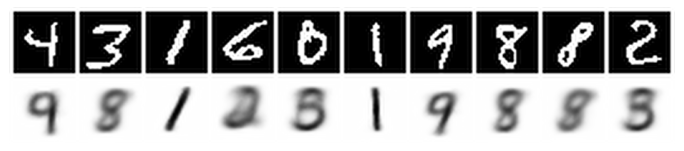

In [29]:
drow_reconstruction(vae_d2, test_data, num_samples=10)

генерация объектов из латентного пространства

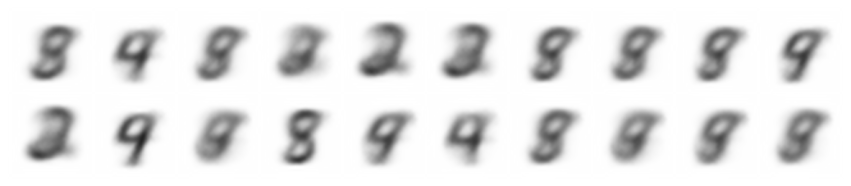

In [31]:
show_images(vae_d2.generate_samples(20).detach().cpu())

отображение латентного пространства

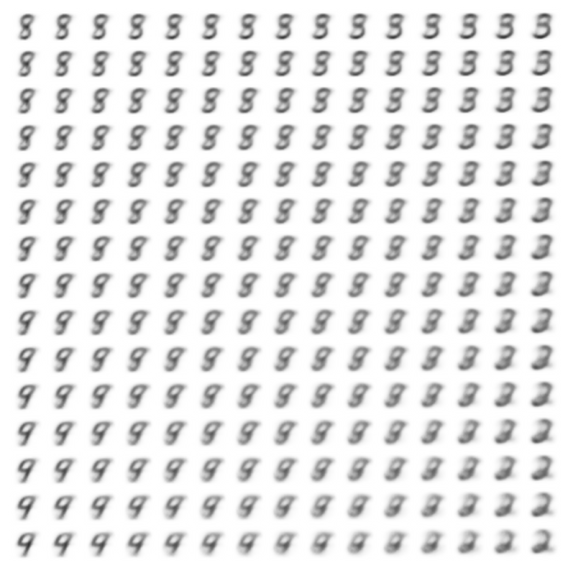

In [32]:
draw_manifold_ae(vae_d2)

как выглядит карта латентного пространства

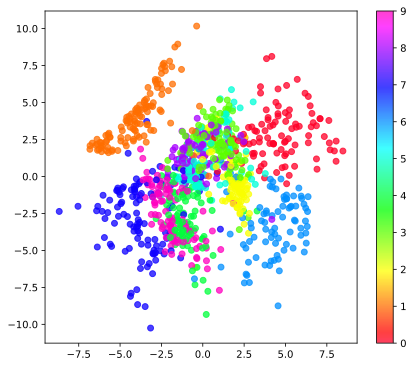

In [36]:
draw_latent_space(test_data_raw.tensors[0][::10], test_data_raw.tensors[1][::10],
                  lambda data: vae_d2.cpu().encode(data).detach().cpu())

## Как себя поведет VAE с 10 мерным латентным пространством

In [37]:
vae_d10 = VAE(10, 784)
vae_d10.to('cuda')
vae_d10_train_log = train_model(vae_d10.parameters(), vae_d10.batch_vlb, train_data,
                               test_data=test_data, num_samples=1000,
                               maximization=True, num_epochs=50)
torch.save(vae_d10.state_dict(), 'variational_auto_encoder_experiment_10d.dill')

Train loss: -445.832: 100%|██████████| 938/938 [00:02<00:00, 377.27it/s]


In [11]:
vae_d10 = VAE(10, 784)
vae_d10.to('cuda')
vae_d10.load_state_dict(torch.load('variational_auto_encoder_experiment_10d.dill'))

<All keys matched successfully>

реконструкция

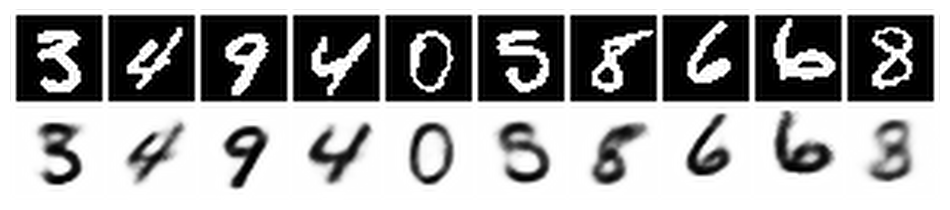

In [12]:
drow_reconstruction(vae_d10, test_data, num_samples=10)

генерация объектов из латентного пространства

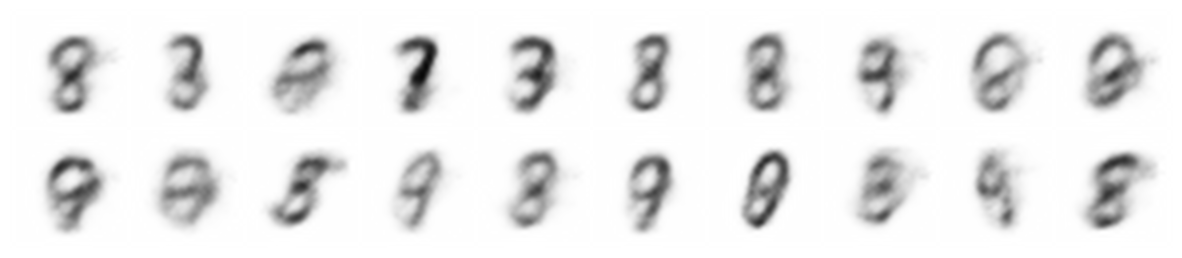

In [13]:
show_images(vae_d10.generate_samples(20).detach().cpu())

как выглядит карта латентного пространства

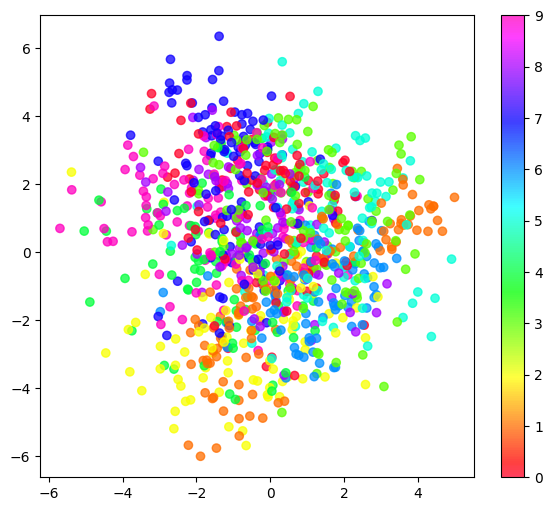

In [14]:
draw_latent_space(test_data_raw.tensors[0][::10], test_data_raw.tensors[1][::10],
                  lambda data: vae_d10.cpu().encode(data).detach().cpu())

## Заключение к теоретической части про VAE

Вариационный автоэнкодер удобно воспринимать как точку, в которой идея автоэнкодера “перестраивается” из инженерной схемы реконструкции в полноценную вероятностную модель.

- Во-первых, в VAE явно фиксируется генеративная история: латентная переменная $z$ рассматривается как источник вариативности, из которого декодер задаёт распределение объектов $p_\theta(x\mid z)$. Благодаря этому у модели появляется корректная процедура генерации: достаточно сэмплировать $z\sim p(z)$ и затем получить $x\sim p_\theta(x\mid z)$. Это ровно то, чего не хватало детерминированному автоэнкодеру: там декодер тоже переводил $z$ в $x$, но оставалось неясным, откуда брать “правильные” $z$.

- Во-вторых, трудность обучения латентных генеративных моделей оказалась не философской, а технической: в $\log p_\theta(x)$ стоит интеграл по $z$, и именно он мешает прямой максимизации правдоподобия. Вариационный ход (введение $q_\phi(z\mid x)$ и ELBO) не устраняет эту трудность “магией”, а аккуратно заменяет недоступное вычисление на оптимизацию вычислимой нижней оценки. В итоге появляется конструкция, где одновременно обучаются две части: генеративная ($\theta$) и инференсная ($\phi$).

- В-третьих, KL-слагаемое в ELBO следует воспринимать не как “регуляризацию для красоты”, а как механизм, который формирует геометрию латентного пространства и делает prior действительно пригодным для семплирования. При этом важно помнить: VAE всегда живёт в компромиссе. Один член функционала требует точного объяснения данных, другой — согласованности латента с простым prior. На практике именно из этого компромисса возникают характерные режимы и эффекты: от гладких интерполяций и удобства семплирования до ситуаций, когда модель предпочитает “сэкономить” на латентной информации или когда простая модель наблюдений приводит к усреднению деталей.

Наконец, VAE ценен не только как самостоятельный генератор. Он даёт структурированный интерфейс между $\mathcal{X}$ и $\mathcal{Z}$: компактное представление с понятным prior и декодер, переводящий латент обратно в данные. Это делает VAE естественным кандидатом на роль базового модуля в более крупных генеративных системах — там, где “сложная” генерация строится уже поверх $\mathcal{Z}$.

Далее, опираясь на эти идеи, можно обсуждать применения: сначала — как использовать VAE как модель представлений и инференса, а затем — как он работает в роли generative backbone для других генеративных моделей (в частности, в латентных диффузионных подходах).

# Применение VAE на практике